In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

# import json
# import matplotlib
# s = json.load(open("../../styles/bmh_matplotlibrc.json"))
# matplotlib.rcParams.update(s)

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Flatten, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D, Embedding
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model, Sequential
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: []


In [3]:
def plot_samples(samples):
    fig = plot.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plot.subplot(gs[i])
        plot.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plot.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig

def show_images(rows, cols, real, fake):
    n = rows * cols
    fake_images = fake.reshape(-1, 28, 28)[:n//2]
    real_images = real.reshape(-1, 28, 28)[:n//2]
    for i, (img_f, img_r) in enumerate(zip(fake_images, real_images)):
        plot.subplot(rows, cols, 2*i+1)
        plot.imshow(img_r, cmap=plot.cm.gray)
        plot.axis('off')    
        plot.subplot(rows, cols, 2*i+2)
        plot.imshow(img_f, cmap=plot.cm.gray)
        plot.axis('off')    

def sample_Z(m):
    return np.random.uniform(-1.0, 1.0, size=[m, latent_dim])

def sample_X(m):
    return X_train[np.random.randint(0.0, X_train.shape[0], size=m)]

def make_trainable(net, val=True):
    net.trainable = val
    for layer in net.layers:
        layer.trainable = val

In [4]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print('X_train shape:', X_train.shape, X_train.dtype)
print('X_train min/max:', np.min(X_train), np.max(X_train))


X_train shape: (60000, 784) float32
X_train min/max: 0.0 1.0


In [5]:
M = 512
N = 256
latent_dim = 100

g_opt = Adam()
d_opt = Adam()

# g_opt = RMSprop()
# d_opt = RMSprop()

# Generator Model
Ghd1 = Dense(M, activation='relu', name='ghd1')
Ghd2 = Dense(M, activation='relu', name='ghd2')
Gout = Dense(784, activation='sigmoid', name='gout')

inp = Input(shape=(latent_dim,))
hid = Ghd1(inp)
hid = BatchNormalization()(hid)
hid = Dropout(0.5)(hid)
hid = Ghd2(hid)
hid = BatchNormalization()(hid)
hid = Dropout(0.5)(hid)
out = Gout(hid)
G = Model(inp, out)
             
# Discriminator Model
Dhd1 = Dense(N, activation='relu', name='dhd1')
Dhd2 = Dense(N, activation='relu', name='dhd2')
Dout = Dense(1, activation='sigmoid', name='dout')

inp = Input(shape=(784,))
hid = Dhd1(inp)
hid = Dropout(0.5)(hid)
hid = Dhd2(hid)
hid = Dropout(0.5)(hid)
out = Dout(hid)
D = Model(inp, out)
D.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=['accuracy'])

# Generator-Discriminator: Adversarial Model
make_trainable(D, False)    # To freeze a layer, you can set its 'trainable' property to 
                            # True or False after instantiation. For this to take effect, 
                            # you will need to call compile() on your model after 
                            # modifying the trainable property. (from Keras docs)
inp = Input(shape=(latent_dim,))
hid = G(inp)
out = D(hid)
GAN = Model(inp, out)
GAN.compile(loss='binary_crossentropy', optimizer=g_opt, metrics=['accuracy'])

# G.summary()
# D.summary()
# GAN.summary()

Training data shapes: (100, 784) (100, 1)
Epoch 1/1
 32/100 [========>.....................] - ETA: 0sAccuracy: 0.99


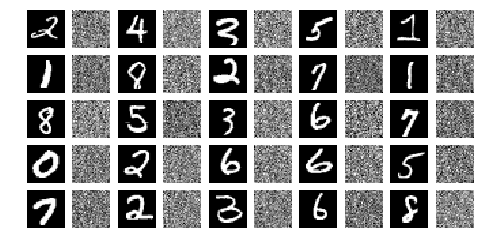

In [6]:
ntrain = 50

# Real images
real_images = sample_X(ntrain)
real_targets = np.ones((ntrain, 1))

# Fake images
fake_images = G.predict(sample_Z(ntrain))
fake_targets = np.zeros((ntrain, 1))

figsize(8, 4)
show_images(5, 10, real_images, fake_images)

# Train discriminator these images
X = np.vstack((real_images,  fake_images))
y = np.vstack((real_targets, fake_targets))

print('Training data shapes:', X.shape, y.shape)

D.fit(X, y, epochs=1, batch_size=32)

loss, acc = D.evaluate(X, y)
print('Accuracy:', acc)


In [7]:
img_dir = 'gan_mnist'
losses = dict(g=[], d=[])

def trainIt(nepochs, batch_size=32, pint=10):

    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    
    t0 = time.time()
    for i in range(nepochs):
        
        # Real images
        real_images = sample_X(batch_size)
        real_targets = np.ones((batch_size, 1))
        
        # Fake images
        fake_images = G.predict(sample_Z(batch_size))
        fake_targets = np.zeros((batch_size, 1))
        
        # Train discriminator these images and targets
        # --------------------------------------------
        X = np.vstack((real_images,  fake_images))
        y = np.vstack((real_targets, fake_targets))
        
        d_loss, d_acc  = D.train_on_batch(X, y)
        losses["d"].append((d_loss, d_acc))
    
        # Train Generator-Discriminator stack on input noise
        # --------------------------------------------------
        Z = sample_Z(batch_size)
        t = np.ones([batch_size, 1])

        g_loss, g_acc = GAN.train_on_batch(Z, t)
        losses["g"].append((g_loss, g_acc))
        
        if i%pint == 0:
            print('{:6d} -- G = {:.5f}, {:.5f};  D = {:.5f}, {:.5f};  [{:.1f}s]'.\
                  format(i, g_loss, g_acc, d_loss, d_acc, time.time() - t0))
            t0 = time.time()

            samples = G.predict(sample_Z(16))

            fig = plot_samples(samples)
            plot.savefig('{}/img_{}.png'.format(img_dir, str(i).zfill(5)), bbox_inches='tight')
            plot.close(fig)
            

In [8]:
Niter = 50000
Nimg = 5000

figsize(8, 8)
try:
    trainIt(Niter+1, batch_size=32, pint=Nimg)
    
except KeyboardInterrupt:
    pass

     0 -- G = 3.59128, 0.00000;  D = 0.30724, 0.89062;  [4.0s]
  5000 -- G = 2.19249, 0.12500;  D = 0.35636, 0.84375;  [138.5s]
 10000 -- G = 2.02245, 0.09375;  D = 0.40082, 0.81250;  [140.5s]
 15000 -- G = 1.51270, 0.12500;  D = 0.42504, 0.81250;  [142.4s]
 20000 -- G = 1.52066, 0.18750;  D = 0.41578, 0.79688;  [138.7s]
 25000 -- G = 1.54702, 0.12500;  D = 0.43371, 0.85938;  [141.1s]
 30000 -- G = 1.33335, 0.21875;  D = 0.39357, 0.82812;  [140.7s]
 35000 -- G = 1.88925, 0.21875;  D = 0.34205, 0.82812;  [146.8s]
 40000 -- G = 1.50842, 0.31250;  D = 0.30871, 0.87500;  [149.1s]
 45000 -- G = 1.99603, 0.09375;  D = 0.34722, 0.82812;  [144.5s]
 50000 -- G = 2.10129, 0.25000;  D = 0.28387, 0.90625;  [142.7s]


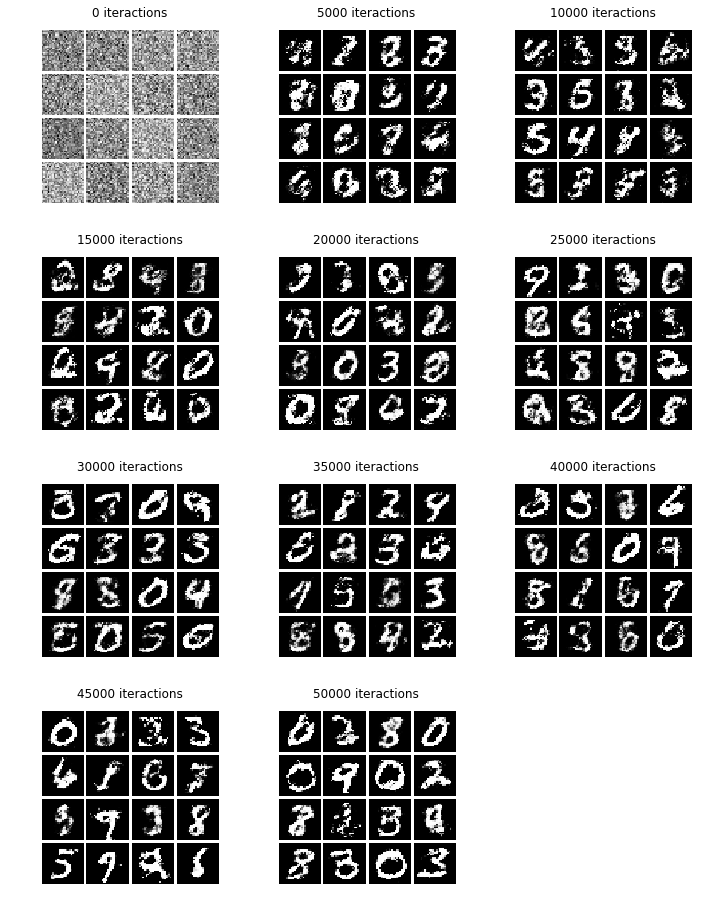

In [9]:
m = int(np.ceil(((Niter+1) // Nimg + 1) / 3))
fig = plot.figure(figsize=(12, 4*m))

shape = (100, 100)
for i, fn in enumerate(range(0, Niter+1, Nimg)):
    fig.add_subplot(m, 3, i+1)
    image_fn = '{}/img_{:05d}.png'.format(img_dir, fn)
    if os.path.isfile(image_fn):
        img = plot.imread(image_fn)
        shape = img.shape
    else:
        img = 0.5*np.ones(shape)
    plot.imshow(img, cmap='gray')
    plot.axis('off')
    plot.title('{} iteractions'.format(fn))
    
# plt.show()

In [10]:
real = sample_X(10)

noise = sample_Z(10)
fake = G.predict(noise)

y1 = GAN.predict(noise)
y2 = D.predict(fake)
y3 = D.predict(real)

print(y1.T - y2.T)
print(y2[:,0].T)
print(y3[:,0].T)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[ 0.112  0.107  0.055  0.07   0.02   0.096  0.163  0.036  0.077  0.01 ]
[ 0.853  0.983  1.     0.993  0.608  0.988  0.963  0.964  0.991  0.949]


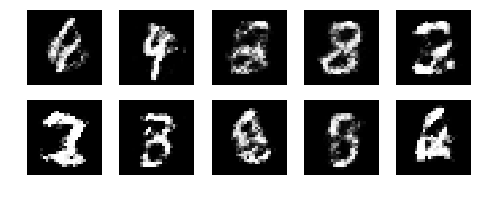

In [11]:
fake_images = fake.reshape(10, 28, 28)

figsize(8, 8)
for i, img in enumerate(fake_images):
    plot.subplot(5, 5, i+1)
    plot.imshow(img, cmap=plot.cm.gray)
    plot.axis('off')    

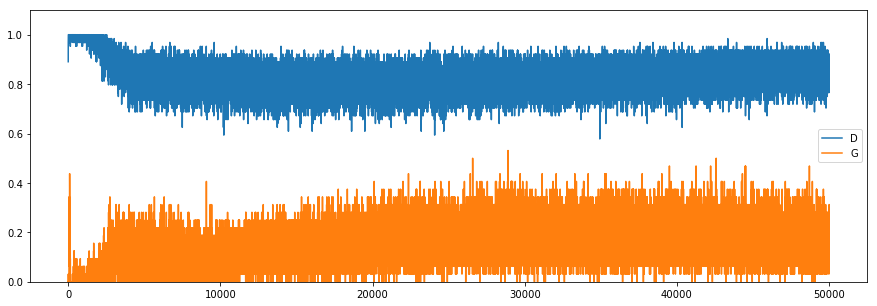

In [12]:
fig = plot.figure(figsize=(15, 5))

d_acc = [b for a, b in losses['d']]
g_acc = [b for a, b in losses['g']]

plot.plot(d_acc, label='D')
plot.plot(g_acc, label='G')
plot.ylim(0, 1.1)
plot.legend()